<a href="https://colab.research.google.com/github/nandinib1999/edureka-assignments/blob/main/Edureka_Sequence_Learning_Assignment_4_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/Hindi_English_Truncated_Corpus.csv")
data.shape

(127607, 3)

In [2]:
data.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127607 entries, 0 to 127606
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   source            127607 non-null  object
 1   english_sentence  127605 non-null  object
 2   hindi_sentence    127607 non-null  object
dtypes: object(3)
memory usage: 2.9+ MB


In [4]:
data.isna().sum()

source              0
english_sentence    2
hindi_sentence      0
dtype: int64

In [5]:
data = data[~data.isna().any(axis=1)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127605 entries, 0 to 127606
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   source            127605 non-null  object
 1   english_sentence  127605 non-null  object
 2   hindi_sentence    127605 non-null  object
dtypes: object(3)
memory usage: 3.9+ MB


In [6]:
data.isna().sum()

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

In [7]:
data.drop_duplicates(inplace=True)
data.shape

(124827, 3)

In [8]:
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [9]:
import re

def preprocessing(string):
  string = string.lower()
  string = re.sub("[!\"#$%&'\(\)*+,-./:;<=>?@\[\\\\\]^\_`\{\|\}~“”]", " ", string)
  string = re.sub("[0-9]", " ", string)
  string = re.sub("[२३०८१५७९४६।]", " ", string)
  string = re.sub("\s+", " ", string)
  return string

In [10]:
data['english_sentence'] = data['english_sentence'].apply(lambda x: preprocessing(x))
data.head(10)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,i d like to tell you about one such child,मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,this percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they re bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,the ending portion of these vedas is called u...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।
5,tides,the then governor of kashmir resisted transfer...,कश्मीर के तत्कालीन गवर्नर ने इस हस्तांतरण का व...
6,indic2012,in this lies the circumstances of people befor...,इसमें तुमसे पूर्व गुज़रे हुए लोगों के हालात हैं।
7,ted,and who are we to say even that they are wrong,और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
8,indic2012,global warming refer to warming caused in rec...,ग्लोबल वॉर्मिंग से आशय हाल ही के दशकों में हुई...
9,tides,you may want your child to go to a school that...,हो सकता है कि आप चाहते हों कि आप का नऋर्नमेनटे...


In [11]:
data['hindi_sentence'] = data['hindi_sentence'].apply(lambda x: preprocessing(x))
data.head(10)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करन...
1,ted,i d like to tell you about one such child,मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,this percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है
3,ted,what we really mean is that they re bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,the ending portion of these vedas is called u...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है
5,tides,the then governor of kashmir resisted transfer...,कश्मीर के तत्कालीन गवर्नर ने इस हस्तांतरण का व...
6,indic2012,in this lies the circumstances of people befor...,इसमें तुमसे पूर्व गुज़रे हुए लोगों के हालात हैं
7,ted,and who are we to say even that they are wrong,और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
8,indic2012,global warming refer to warming caused in rec...,ग्लोबल वॉर्मिंग से आशय हाल ही के दशकों में हुई...
9,tides,you may want your child to go to a school that...,हो सकता है कि आप चाहते हों कि आप का नऋर्नमेनटे...


In [12]:
data=data.sample(n=25000,random_state=42)
data.shape

(25000, 3)

In [13]:
eng_vocab = []
eng_sentences = data['english_sentence'].tolist()
eng_maxlen = 0
for sent in eng_sentences:
  words = sent.split(" ")
  words = [x.strip() for x in words if len(x.strip()) > 0]
  if eng_maxlen < len(words):
    eng_maxlen = len(words)
  eng_vocab.extend(words)


hindi_vocab = []
hindi_sentences = data['hindi_sentence'].tolist()
hindi_maxlen = 0
for sent in hindi_sentences:
  words = sent.split(" ")
  words = [x.strip() for x in words if len(x.strip()) > 0]
  if hindi_maxlen < len(words):
    hindi_maxlen = len(words)
  hindi_vocab.extend(words)


unq_eng_vocab = list(set(eng_vocab))
unq_hindi_vocab = list(set(hindi_vocab))

print("English Vocab:", len(unq_eng_vocab))
print("Hindi Vocab:", len(unq_hindi_vocab))

English Vocab: 28076
Hindi Vocab: 34225


In [14]:
from collections import Counter

def word_count(vocabulary):
    ct = Counter(vocabulary)
    words = []
    cnt = []
    for i, j in ct.items():
      if i != "<start>" and i != "<end>":
        words.append(i)
        cnt.append(j)
    data = {"word":words , "count":cnt}
    df = pd.DataFrame(data)
    df = df.sort_values(by='count', ascending=False)
    df = df.reset_index()[["word","count"]]
    return df

In [15]:
word_cnt = word_count(eng_vocab)
word_cnt.head(20)

,word,count
0,the,26140
1,of,15128
2,and,11725
3,to,9715
4,in,9512
5,a,7486
6,is,6043
7,that,3961
8,it,3616
9,for,3236


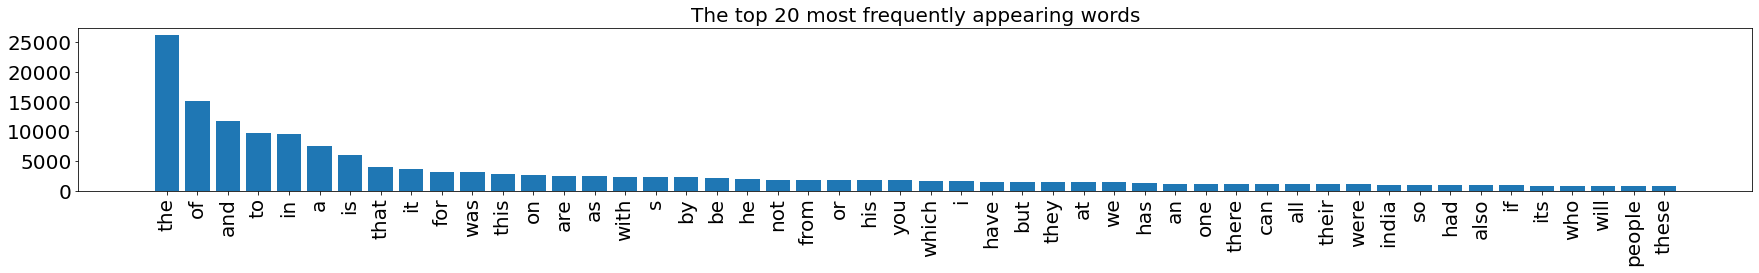

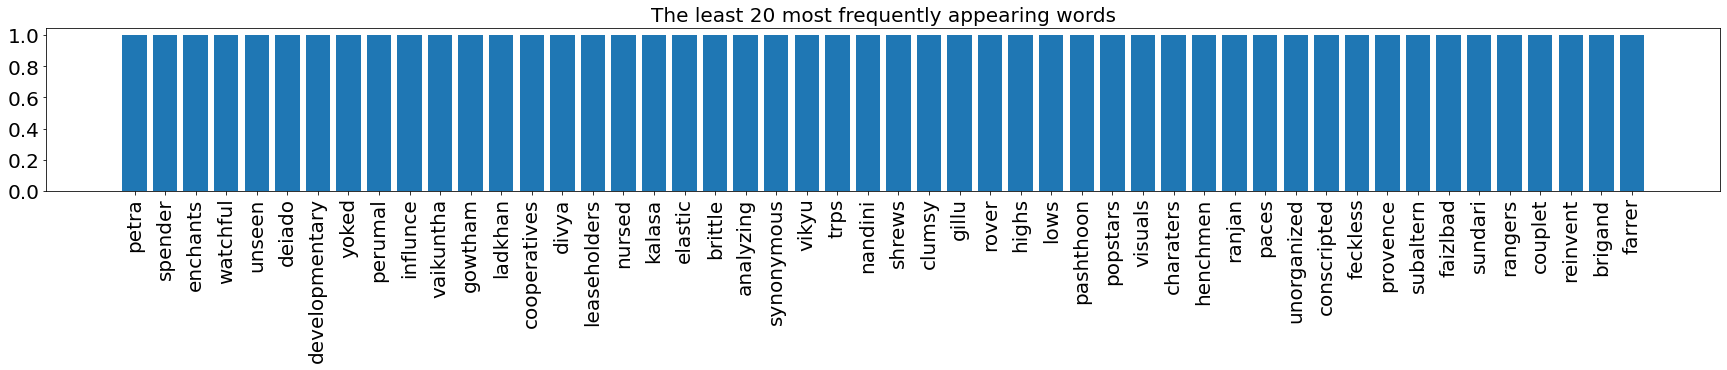

In [16]:
import matplotlib.pyplot as plt

topn = 50

def plot_word_count(df, title):
    plt.figure(figsize=(30,3))
    plt.bar(df.index, df["count"])
    plt.yticks(fontsize=20)
    plt.xticks(df.index,df["word"], rotation=90, fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()

plot_word_count(word_cnt[:topn], title="The top 20 most frequently appearing words")
print()
plot_word_count(word_cnt[-topn:], title="The least 20 most frequently appearing words")

In [17]:
data['hindi_sentence'] = data['hindi_sentence'].apply(lambda x: "<start> "+x+" <end>")

In [18]:
data.head(20)

,source,english_sentence,hindi_sentence
25520,indic2012,islam is word from arabic and it full word is ...,<start> इस्लाम शब्द अरबी भाषा का शब्द है जिसका...
118633,ted,everything is reliant on these computers working,<start> इन कंप्यूटरों पर सब कुछ निर्भर है <end>
113495,tides,parliament does not control the government,<start> संसद का सरकार पपर नियंत्रण नपहीं रहता ...
29783,tides,race equality new laws,<start> नये कानून नस्ली समानता <end>
111804,tides,the provision would not affect the power of pa...,<start> व्यवसायों आदि से होने वाली आय के बारे ...
44718,tides,from the top of the adhishthana at about the m...,<start> उत्तरी दिशा के लगभग मध्य में अधिष्ठान ...
57202,ted,there was lasagna there was casseroles,<start> वहां लाजान्या था कैसेरोल थे <end>
107821,indic2012,super power india source google writer vedprat...,<start> महाशक्ति भारत गूगल पुस्तक लेखक वेदप्रत...
85746,tides,each was a blow to conservatism,<start> इनमें से प्रत्येक यथास्थितिवादियों पर ...
81085,tides,if he is satisfied that the matter is urgent a...,<start> यदि उसका समाधान हो जाए कि मामला इतना अ...


In [19]:
unq_hindi_vocab.append('<start>')
unq_hindi_vocab.append('<end>')

In [20]:
data['eng_sent_len'] = data['english_sentence'].apply(lambda x:len(x.split(" ")))
data['hindi_sent_len'] = data['hindi_sentence'].apply(lambda x:len(x.split(" ")))
data.head(20)

,source,english_sentence,hindi_sentence,eng_sent_len,hindi_sent_len
25520,indic2012,islam is word from arabic and it full word is ...,<start> इस्लाम शब्द अरबी भाषा का शब्द है जिसका...,15,22
118633,ted,everything is reliant on these computers working,<start> इन कंप्यूटरों पर सब कुछ निर्भर है <end>,8,10
113495,tides,parliament does not control the government,<start> संसद का सरकार पपर नियंत्रण नपहीं रहता ...,7,10
29783,tides,race equality new laws,<start> नये कानून नस्ली समानता <end>,4,6
111804,tides,the provision would not affect the power of pa...,<start> व्यवसायों आदि से होने वाली आय के बारे ...,23,25
44718,tides,from the top of the adhishthana at about the m...,<start> उत्तरी दिशा के लगभग मध्य में अधिष्ठान ...,34,34
57202,ted,there was lasagna there was casseroles,<start> वहां लाजान्या था कैसेरोल थे <end>,7,8
107821,indic2012,super power india source google writer vedprat...,<start> महाशक्ति भारत गूगल पुस्तक लेखक वेदप्रत...,9,10
85746,tides,each was a blow to conservatism,<start> इनमें से प्रत्येक यथास्थितिवादियों पर ...,7,11
81085,tides,if he is satisfied that the matter is urgent a...,<start> यदि उसका समाधान हो जाए कि मामला इतना अ...,41,49


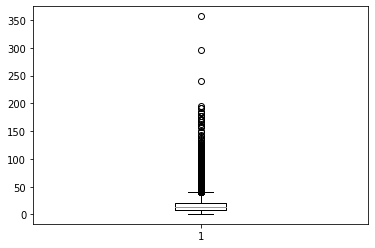

In [21]:
plt.boxplot(data['eng_sent_len'])
plt.show()

In [22]:
df = data[data['eng_sent_len'] <= 50]

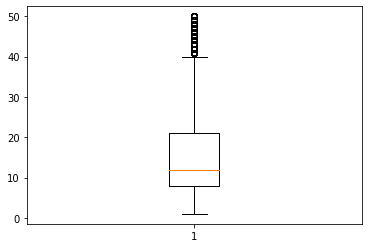

In [23]:
plt.boxplot(df['eng_sent_len'])
plt.show()

(array([3049., 6775., 5192., 3254., 2381., 1573., 1015.,  616.,  405.,
         226.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <a list of 10 Patch objects>)

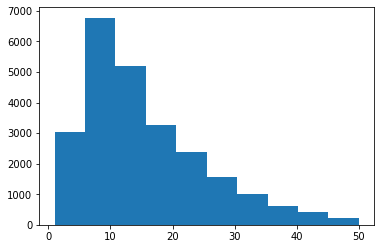

In [24]:
plt.hist(df['eng_sent_len'])

(array([2.1884e+04, 2.4970e+03, 8.1000e+01, 1.0000e+01, 5.0000e+00,
        6.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  3. ,  34.2,  65.4,  96.6, 127.8, 159. , 190.2, 221.4, 252.6,
        283.8, 315. ]),
 <a list of 10 Patch objects>)

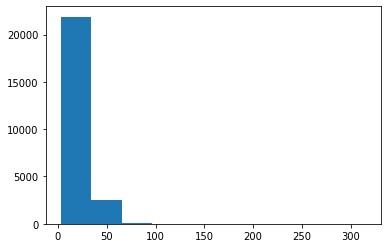

In [25]:
plt.hist(df['hindi_sent_len'])

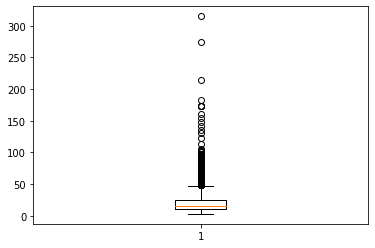

In [26]:
plt.boxplot(df['hindi_sent_len'])
plt.show()

In [27]:
df = df[df['hindi_sent_len'] <= 50]

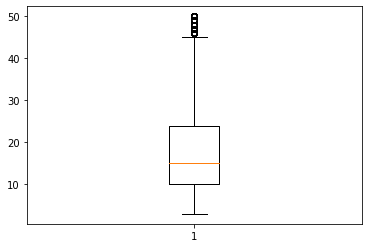

In [28]:
plt.boxplot(df['hindi_sent_len'])
plt.show()

(array([2785., 5937., 5107., 2757., 2555., 1956., 1043.,  880.,  615.,
         400.]),
 array([ 3. ,  7.7, 12.4, 17.1, 21.8, 26.5, 31.2, 35.9, 40.6, 45.3, 50. ]),
 <a list of 10 Patch objects>)

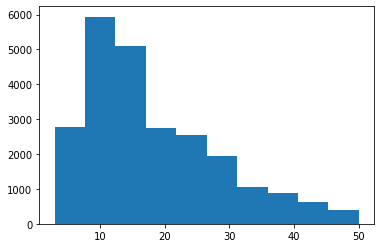

In [29]:
plt.hist(df['hindi_sent_len'])

In [30]:
print("Earlier:", data.shape)
print("Now:", df.shape)

Earlier: (25000, 5)
Now: (24035, 5)


In [31]:
target_max_length = max(df['hindi_sent_len'])
source_max_length = max(df['eng_sent_len'])

print("Maximum length of Hindi Sentence:", target_max_length)
print("Maximum length of English Sentence:", source_max_length)

Maximum length of Hindi Sentence: 50
Maximum length of English Sentence: 50


In [32]:
eng_id2word = {}
eng_word2id = {}
for indx, word in enumerate(unq_eng_vocab):
    eng_word2id[word] = indx
    eng_id2word[indx] = word

In [33]:
hindi_id2word = {}
hindi_word2id = {}
for indx, word in enumerate(unq_hindi_vocab):
    hindi_word2id[word] = indx
    hindi_id2word[indx] = word

In [34]:
eng_word2id['is']

18826

In [35]:
hindi_word2id["राजनीतिज्ञों"]

27641

In [36]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [37]:
df = shuffle(df)
df.head(10)

,source,english_sentence,hindi_sentence,eng_sent_len,hindi_sent_len
28334,ted,the doors open the kids descend on this table ...,<start> तो दरवाजा खुलता है बच्चे टांगों भरी मे...,12,13
56229,ted,or just like you really,<start> या एकदम आपकी तरह से वाकई <end>,6,9
72189,ted,you ve all heard about things like stuxnet,<start> आप सब ने stuxnet तरह की चीजों के बारे ...,9,15
76749,indic2012,cuisines of dravidian region are called south ...,<start> दक्षिण भारतीय खाना भारत के द्रविड़ राज...,10,16
124666,indic2012,in mumbai the population of families from was ...,<start> मुंबई में प्रवारियों की संख्या में लाख...,17,20
108635,tides,they learn the sounds that letters make,<start> वे ध्वनियों को सीखते हैं जो अक्षर बनात...,8,12
113754,indic2012,evidences from the stone age and iron age have...,<start> पाषाण या प्रस्तर युग का जन्म और विकास ...,13,18
104190,ted,okay so the great majority of us,<start> ठीक तो हम में ज्यादातर लोगों ने <end>,8,10
35525,ted,and economic development and security,<start> और आर्थिक विकास और सुरक्षा <end>,6,8
84657,tides,but we have to put up with these disadvantages...,<start> चूंकि हमारे लिए कोई दूसरा रास्ता नहीं ...,19,19


In [38]:
X, y = df['english_sentence'], df['hindi_sentence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((19228,), (4807,))

In [39]:
num_encoder_tokens = len(unq_eng_vocab)
num_decoder_tokens = len(unq_hindi_vocab)

In [40]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
  ''' Generate a batch of data '''
  while True:
      for j in range(0, len(X), batch_size):
          encoder_input_data = np.zeros((batch_size, source_max_length), dtype='float32')
          decoder_input_data = np.zeros((batch_size, target_max_length), dtype='float32')
          decoder_target_data = np.zeros((batch_size, target_max_length, num_decoder_tokens), dtype='float32')
          for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
              for t, word in enumerate(input_text.split()):
                  encoder_input_data[i, t] = eng_word2id[word] # encoder input seq
              for t, word in enumerate(target_text.split()):
                  if t<len(target_text.split())-1:
                      decoder_input_data[i, t] = hindi_word2id[word] # decoder input seq
                  if t>0:
                      decoder_target_data[i, t - 1, hindi_word2id[word]] = 1.
          yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [41]:
latent_dim=300

In [42]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [43]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [44]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [45]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    8422800     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    10268100    input_2[0][0]                    
______________________________________________________________________________________________

In [47]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 100

In [ ]:
!mkdir "saved_model"

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

es = EarlyStopping(monitor="val_loss", mode="min", patience=5)
checkpt = ModelCheckpoint("/content/saved_model", monitor='val_loss', mode='min', save_best_only=True, verbose=1)

history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=[es, checkpt])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
150/150 [==============================] - 131s 791ms/step - loss: 2.3573 - val_loss: 2.2193
Epoch 2/100
150/150 [==============================] - 117s 783ms/step - loss: 2.1546 - val_loss: 2.1121
Epoch 3/100
150/150 [==============================] - 138s 920ms/step - loss: 2.0415 - val_loss: 2.0484
Epoch 4/100
150/150 [==============================] - 138s 922ms/step - loss: 1.9599 - val_loss: 2.0133
Epoch 5/100
150/150 [==============================] - 118s 785ms/step - loss: 1.8962 - val_loss: 1.9901
Epoch 6/100
150/150 [==============================] - 118s 790ms/step - loss: 1.8379 - val_loss: 1.9699
Epoch 7/100
150/150 [==============================] - 118s 790ms/step - loss: 1.7838 - val_loss: 1.9549
Epoch 8/100
150/150 [==============================] - 117s 784ms/step - loss: 1.7299 - val_loss: 1.9406
Epoch 9/100
150/150 [==============================] - 117s 783ms/step - loss: 1.6817 - val_loss: 1.9259
Epoch 10/100
150/150 [==============================] -

KeyboardInterrupt: ignored

In [50]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored